Sales Forecasting
#2. Univariate modeling
## 2-4. Deterministic process

In [19]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import lightgbm as lgb

In [2]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [3]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [4]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [5]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [6]:
train_df = plot_by_family(train, 44, [TARGET], True)

## 1) Fourier component를 반영한 deterministic process
* CalendarFourier를 이용하여 다양한 주기를 갖는 fourier term 계산 (seasonality 반영)
* deterministic process에 이를 반영하여 trend, seasonality정보 계산
* vector space model 기반 예측 수행

In [7]:
valid_ratio = 0.7

In [8]:
train_period = int(train_df.shape[0]*valid_ratio)
trains = train_df.iloc[:train_period]
valids = train_df.iloc[train_period:]

trains.shape, valids.shape

((1178, 2), (506, 2))

* CalendarFourier를 사용하기 위한 데이터 타입 수정

In [9]:
trains['date'] = pd.to_datetime(trains.date).dt.to_period('D').copy()
valids['date'] = pd.to_datetime(valids.date).dt.to_period('D').copy()

<ipython-input-9-56d30fd01141>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-56d30fd01141>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
fourier = CalendarFourier(freq='Y', order=20)

dp = DeterministicProcess(
    index = trains.date,
    constant = True,
    order = 1,
    seasonal = True,
    additional_terms = [fourier],
    drop = True,
)

X = dp.in_sample()

In [11]:
X.head(3)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(16,freq=A-DEC)","cos(16,freq=A-DEC)","sin(17,freq=A-DEC)","cos(17,freq=A-DEC)","sin(18,freq=A-DEC)","cos(18,freq=A-DEC)","sin(19,freq=A-DEC)","cos(19,freq=A-DEC)","sin(20,freq=A-DEC)","cos(20,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.271958,0.962309,0.288482,0.957485,0.304921,0.952378,0.321270,0.946988,0.337523,0.941317
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.523416,0.852078,0.552435,0.833556,0.580800,0.814046,0.608477,0.793572,0.635432,0.772157


## 2-1) Ridge regression 기반 예측
* RMSE: 306.55

In [13]:
model = Ridge().fit(X, trains[TARGET]) # LinearRegression
y_pred = pd.Series(model.predict(X), index=X.index)

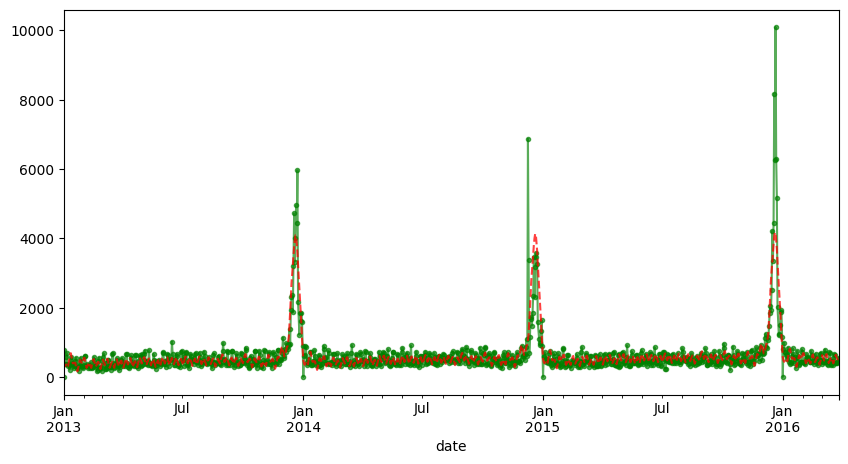

In [14]:
plt.figure(figsize=(10, 5))
ax = trains.set_index('date')[TARGET].plot(alpha=0.65, style='.-', color='g')
ax = y_pred.plot(ax=ax, alpha=0.75, color='r', style='--')

In [15]:
vals = dp.out_of_sample(steps=valids.shape[0])
vals.shape

(506, 48)

In [16]:
preds = pd.Series(model.predict(vals), index=vals.index)

<Axes: xlabel='date'>

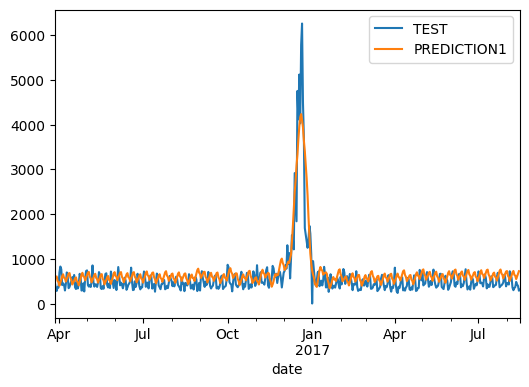

In [17]:
valids.set_index('date')[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds.plot(legend=True, label='PREDICTION1')

In [18]:
print(f'MAE = {mean_absolute_error(valids[TARGET], preds)}')
print(f'MSE = {mean_squared_error(valids[TARGET], preds)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], preds))}')

MAE = 213.70489410856896
MSE = 93973.71379034658
RMSE = 306.5513232565578


## 2-2) LightGBM 이용한 예측
* RMSE: 331.02
* Ridge regression 보다 성능이 낮음
* peak에서 예측값이 뭉뚝한 것으로 보아 tree 기반 모형 특성상 외삽의 경우 예측값이 일정한 부분이 반영된 듯하여 보임

In [34]:
param = {}
param["objective"] = "regression"
param["boosting_type"] = "gbdt"
param["metric"] = "rmse"
param["max_depth"] = -1
param["learning_rate"] = 0.01

In [35]:
lgb_reg = lgb.LGBMRegressor(**param)

In [28]:
X.columns = [f"X_{i+1}" for i in range(X.shape[1])]
vals.columns = [f"X_{i+1}" for i in range(X.shape[1])]

In [36]:
lgb_reg.fit(
    X=X,
    y=trains[TARGET],
    eval_set = [(X, trains[TARGET])],
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50, verbose=False)],
)

[100]	training's rmse: 401.37


LGBMRegressor(learning_rate=0.01, metric='rmse', objective='regression')

In [37]:
preds_lgb = pd.Series(lgb_reg.predict(vals), index=vals.index)

<Axes: xlabel='date'>

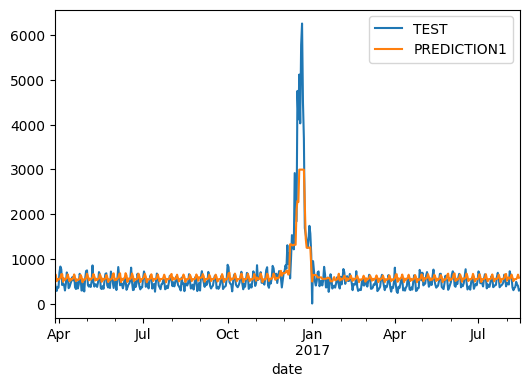

In [38]:
valids.set_index('date')[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds_lgb.plot(legend=True, label='PREDICTION1')

In [39]:
print(f'MAE = {mean_absolute_error(valids[TARGET], preds_lgb)}')
print(f'MSE = {mean_squared_error(valids[TARGET], preds_lgb)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids[TARGET], preds_lgb))}')

MAE = 176.2645414846335
MSE = 109574.88988006381
RMSE = 331.0209810269793
